# setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install sentence_transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 930.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=713f1e3be4a0dfea2f5d13154f1d07c

In [ ]:
# import

import random
import math
import numpy as np
import logging
from datetime import datetime
import pandas as pd
import os
import csv
from typing import List, Union
from tqdm.autonotebook import trange

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util, SentencesDataset
from sentence_transformers.evaluation import SentenceEvaluator, TripletEvaluator
from sentence_transformers.readers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

<ipython-input-3-a0c2e556e394>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


# dataset

In [ ]:
# wa3i 프로젝트 데이터
wa3i_data = pd.read_csv('/content/drive/MyDrive/종설/dataset/science_wai.csv', usecols=['sentence1', 'sentence2', 'gold_label'])
wa3i_data = wa3i_data.dropna(how='any')
wa3i_data

,sentence1,sentence2,gold_label
0,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자가 먹을 것이 없어 죽게되고 분해자도 소비자가 다 죽어 소비자...,entailment
1,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 생태계에 없으면 소비자와 분해자가 먹을것을 못먹는다.못먹는 소비자와 분해자...,entailment
2,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 있지 않으면 생산자를 먹는 동물도 그 동물을 먹는 동물도 굶게 되어 생태계...,entailment
3,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자는 소비자와 분해자들에게 영양을 제공한다. 만약 생산자가 없다면 소비자는 영양...,entailment
4,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자와 분해자는 독립영양을 못하기 때문에 죽게되기 때문이다,entailment
...,...,...,...
8721,부력에 의해 배를 띄울 수 있다.,물이 힘이있어서,contradiction
8722,부력에 의해 배를 띄울 수 있다.,파도를 이용하여 뜨게 하는것 같다,contradiction
8723,부력에 의해 배를 띄울 수 있다.,물체를 띄우는 힘인 부력을 활용한 것이다.,entailment
8724,부력에 의해 배를 띄울 수 있다.,배는 부력의 원리로 뜨기 때문에 물을 사용하면 쉽게 이동시킬 수 있다.,entailment


In [ ]:
# 직접 수집한 데이터
custom_data = pd.read_csv('/content/drive/MyDrive/종설/dataset/science_workbook_custom.csv', usecols=['sentence1', 'sentence2', 'gold_label'])
custom_data = custom_data.dropna(how='any')
custom_data

,sentence1,sentence2,gold_label
0,"중력의 크기는 질량에 비례하고, 자유 낙하 운동에서 낙하 시간은 높이에 의해 결정된다.",중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
1,"중력 크기는 질량과 관련되어 있으며, 자유 낙하로 이동하는데 걸리는 시간은 출발 지...",중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
2,"중력 작용은 물체의 무게와 관련이 있고, 자유 낙하 동안 걸리는 시간은 높이에 좌우된다.",중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
3,중력은 질량에 의해 결정되며 낙하 운동에서 높이는 낙하 시간을 결정하는 중요한 요소...,중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
4,물체의 질량이 증가하면 중력의 힘도 증가합니다 낙하 운동에서 높이가 낮으면 물체가 ...,중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
...,...,...,...
4070,세균 증식을 제어하기 위해 푸른곰팡이가 특별한 화합물을 만들 것입니다.,푸른곰팡이는 세균의 증식을 촉진하는 역할을 합니다.,contradiction
4071,푸른곰팡이는 화합물을 만들어 세균의 증식을 제한할 것입니다.,푸른곰팡이는 세균의 증식을 억제하기 위해 특별한 화합물을 생성합니다,entailment
4072,푸른곰팡이는 화합물을 만들어 세균의 증식을 제한할 것입니다.,푸른곰팡이는 세균의 증식을 촉진하는 역할을 합니다.,contradiction
4073,세균 증식을 억제하기 위해 푸른곰팡이가 특정 화합물을 제조하고 제공할 것입니다.,푸른곰팡이는 세균의 증식을 억제하기 위해 특별한 화합물을 생성합니다,entailment


In [ ]:
# transform to Triplet format

def make_nli_triplet_wa3i(dataset):
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = row['gold_label'].strip()

        add_to_samples(sent1, sent2, label)

    # transform to InputExamples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            entailment_list = list(others['entailment'])
            contradiction_list = list(others['contradiction'])

            # Shuffle the lists to randomize the selection
            random.shuffle(entailment_list)
            random.shuffle(contradiction_list)

            # Use the same anchor for multiple triplets
            anchor = sent1

            for _ in range(15):  # Adjust the number of triplets as needed
                ent = random.choice(entailment_list)
                con = random.choice(contradiction_list)

                input_examples.append(InputExample(texts=[anchor, ent, con]))

    return input_examples

In [ ]:
def make_nli_triplet_custom(dataset):
    # transform to Triplet format
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = str(row['gold_label']).strip()

        add_to_samples(sent1, sent2, label)
        add_to_samples(sent2, sent1, label)  # Also add the opposite

    # transform to InputExamples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            input_examples.append(InputExample(texts=[sent1, random.choice(list(others['entailment'])), random.choice(list(others['contradiction']))]))
            input_examples.append(InputExample(texts=[random.choice(list(others['entailment'])), sent1, random.choice(list(others['contradiction']))]))

    return input_examples

In [ ]:
wa3i_dataset = make_nli_triplet_wa3i(wa3i_data)
wa3i_dataset[0].texts

['생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계의 소비자도 먹이가 없어서 죽게 되어 생태계의 균형이 깨진다.',
 '생산자가없어지면생태계가무너지니까',
 '우리가 살아가기위해서']

In [ ]:
custom_dataset = make_nli_triplet_custom(custom_data)
custom_dataset[0].texts

['중력의 크기는 질량에 비례하고, 자유 낙하 운동에서 낙하 시간은 높이에 의해 결정된다.',
 '중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은 높이에 따라 결정된다.',
 '중력의 크기는 질량에 비례하며, 자유 낙하 운동에서 낙하 시간은 높이와 상관없이 동일하다.']

In [ ]:
print(f'triplet wa3i: {len(wa3i_dataset)}')
print(f'triplet custom: {len(custom_dataset)}')

triplet wa3i: 1560
triplet custom: 3938


In [ ]:
# (wa3i dataset) 6:2:2 split

dataset_size = len(wa3i_dataset)
wa3i_train_size = int(dataset_size * 0.6)
wa3i_validation_size = int(dataset_size * 0.2)
wa3i_test_size = dataset_size - wa3i_train_size - wa3i_validation_size

wa3i_train, wa3i_valid, wa3i_test = random_split(wa3i_dataset, [wa3i_train_size, wa3i_validation_size, wa3i_test_size])

print(f"Training Data Size : {len(wa3i_train)}")
print(f"Validation Data Size : {len(wa3i_valid)}")
print(f"Testing Data Size : {len(wa3i_test)}")

Training Data Size : 936
Validation Data Size : 312
Testing Data Size : 312


In [ ]:
# (custom dataset) 6:2:2 split

dataset_size = len(custom_dataset)
custom_train_size = int(dataset_size * 0.6)
custom_validation_size = int(dataset_size * 0.2)
custom_test_size = dataset_size - custom_train_size - custom_validation_size

custom_train, custom_valid, custom_test = random_split(custom_dataset, [custom_train_size, custom_validation_size, custom_test_size])

print(f"Training Data Size : {len(custom_train)}")
print(f"Validation Data Size : {len(custom_valid)}")
print(f"Testing Data Size : {len(custom_test)}")

Training Data Size : 2362
Validation Data Size : 787
Testing Data Size : 789


In [ ]:
# merge dataset

train_dataset = wa3i_train + custom_train
validation_dataset = wa3i_valid + custom_valid
test_dataset = wa3i_test + custom_test
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 3298
Validation Data Size : 1099
Testing Data Size : 1101


# evaluator

In [ ]:
# Evaluator by train
train_evaluator = TripletEvaluator.from_input_examples(
    train_dataset,
    name="train-evaluator",
)

# Evaluator by validation
valid_evaluator = TripletEvaluator.from_input_examples(
    validation_dataset,
    name="valid-evaluator",
)

# Evaluator by test
test_evaluator = TripletEvaluator.from_input_examples(
    test_dataset,
    name="test-evaluator",
)


In [ ]:
# get loss value

logger = logging.getLogger(__name__)


class LossEvaluator(SentenceEvaluator):

    def __init__(self, loader, loss_model: nn.Module = None, name: str = '', log_dir: str = None,
                 show_progress_bar: bool = False, write_csv: bool = True):

        """
        Evaluate a model based on the loss function.
        The returned score is loss value.
        The results are written in a CSV and Tensorboard logs.
        :param loader: Data loader object
        :param loss_model: loss module object
        :param name: Name for the output
        :param log_dir: path for tensorboard logs
        :param show_progress_bar: If true, prints a progress bar
        :param write_csv: Write results to a CSV file
        """

        self.loader = loader
        self.write_csv = write_csv
        self.logs_writer = SummaryWriter(log_dir=log_dir)
        self.name = name
        self.loss_model = loss_model

        # move model to gpu:  lidija-jovanovska
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        loss_model.to(self.device)

        if show_progress_bar is None:
            show_progress_bar = (
                    logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "loss_evaluation" + ("_" + name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps", "loss"]

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        self.loss_model.eval()

        loss_value = 0
        self.loader.collate_fn = model.smart_batching_collate
        num_batches = len(self.loader)
        data_iterator = iter(self.loader)

        with torch.no_grad():
          for _ in trange(num_batches, desc="Iteration", smoothing=0.05, disable=not self.show_progress_bar):
              sentence_features, labels = next(data_iterator)
              # move data to gpu
              for i in range(0, len(sentence_features)):
                  for key, value in sentence_features[i].items():
                      sentence_features[i][key] = sentence_features[i][key].to(self.device)
              labels = labels.to(self.device)
              loss_value += self.loss_model(sentence_features, labels).item()

        final_loss = loss_value / num_batches
        if output_path is not None and self.write_csv:

            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)

            with open(csv_path, newline='', mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow([epoch, steps, final_loss])

            # ...log the running loss
            self.logs_writer.add_scalar('val_loss',
                                        final_loss,
                                        steps)

        self.loss_model.zero_grad()
        self.loss_model.train()

        return final_loss

# model

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path="BM-K/KoSimCSE-roberta-multitask",
    max_seq_length=869,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])


In [ ]:
# config
num_epochs = 20
batch_size = 32

In [ ]:
train_dataset = SentencesDataset(train_dataset, model=model)

# Train / Valid Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# train model
pretrained_model_name = "KoSimCSE-roberta"
model_save_path = 'output/' + pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use ContrastiveLoss
loss_func = losses.TripletLoss(model)

# warmup steps
warmup_steps = math.ceil(len(train_dataset) * num_epochs / batch_size * 0.5) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

epochs = []
train_list = []
valid_list = []
test_list = []
train_loss_history = []
valid_loss_history = []

# loss evaluator
train_loss_evaluator = LossEvaluator(train_dataloader, loss_model=loss_func, log_dir='logs/', name='train')
valid_loss_evaluator = LossEvaluator(valid_dataloader, loss_model=loss_func, log_dir='logs/', name='valid')

# Training
for epoch in range(num_epochs):
    print(f'{epoch} epoch')
    epochs.append(epoch)
    model.fit(
              train_objectives=[(train_dataloader, loss_func)],
              evaluator=valid_evaluator,
              epochs=1,
              evaluation_steps=int(len(train_dataloader)*0.1),
              warmup_steps=warmup_steps,
              output_path=model_save_path,
              use_amp=False      #Set to True, if your GPU supports FP16 operations
    )

    train = train_evaluator(model)
    train_list.append(train)
    print(f'train => {train}')

    valid = valid_evaluator(model)
    valid_list.append(valid)
    print(f'valid => {valid}')

    # todo: test 데이터 사용 시 주석 해제
    # test = test_evaluator(model)
    # test_list.append(test)
    # print(f'test => {test}')

    train_loss = train_loss_evaluator(model)
    train_loss_history.append(train_loss)
    print(f'train_loss => {train_loss}')

    valid_loss = valid_loss_evaluator(model)
    valid_loss_history.append(valid_loss)
    print(f'valid_loss => {valid_loss}')

0 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9390539721043056
valid => 0.9390354868061874
train_loss => 0.9362490197213796
valid_loss => 1.0047329655715398
1 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9548211036992117
valid => 0.9572338489535942
train_loss => 0.718447383493185
valid_loss => 0.7989306024142674
2 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.966949666464524
valid => 0.9617834394904459
train_loss => 0.5515004489570856
valid_loss => 0.636821539912905
3 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9742268041237113
valid => 0.9708826205641492
train_loss => 0.44762018939050346
valid_loss => 0.5320958171572004
4 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9796846573681018
valid => 0.9754322111010009
train_loss => 0.3522442689595314
valid_loss => 0.44115831085613794
5 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9848392965433597
valid => 0.978161965423112
train_loss => 0.2806545841292693
valid_loss => 0.3624523448092597
6 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9869617950272893
valid => 0.9836214740673339
train_loss => 0.22794566890941217
valid_loss => 0.2940623245068959
7 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9887810794420862
valid => 0.986351228389445
train_loss => 0.18862832767459062
valid_loss => 0.2730131042855127
8 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9896907216494846
valid => 0.9881710646041856
train_loss => 0.16156456289956203
valid_loss => 0.24487153036253792
9 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9939357186173439
valid => 0.9899909008189263
train_loss => 0.13382356413281882
valid_loss => 0.21766491532325744
10 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9945421467556095
valid => 0.991810737033667
train_loss => 0.11442992119834973
valid_loss => 0.1911488103015082
11 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9960582171012735
valid => 0.9909008189262967
train_loss => 0.08869306950901563
valid_loss => 0.16112945271389825
12 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9963614311704063
valid => 0.9909008189262967
train_loss => 0.06970724291526355
valid_loss => 0.14859021263463157
13 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9969678593086719
valid => 0.991810737033667
train_loss => 0.05674648915345852
valid_loss => 0.13341047763824462
14 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9978775015160704
valid => 0.9936305732484076
train_loss => 0.047210303851618216
valid_loss => 0.12719195399965558
15 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9987871437234688
valid => 0.9945404913557779
train_loss => 0.03999317158013582
valid_loss => 0.12047542418752398
16 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9987871437234688
valid => 0.9954504094631483
train_loss => 0.03220794249612551
valid_loss => 0.11268732803208488
17 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9990903577926016
valid => 0.9963603275705186
train_loss => 0.02573266768684754
valid_loss => 0.11701978189604623
18 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9990903577926016
valid => 0.9963603275705186
train_loss => 0.022167114540934563
valid_loss => 0.10720273213727134
19 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/104 [00:00<?, ?it/s]

train => 0.9990903577926016
valid => 0.9963603275705186
train_loss => 0.01795885769220499


# result

In [ ]:
# evaluation valid
valid_evaluator(model, output_path=model_save_path)

0.9963603275705186

In [ ]:
# todo: test 데이터 사용 시 주석 해제
# evaluation test
# test_evaluator(model, output_path=model_save_path)

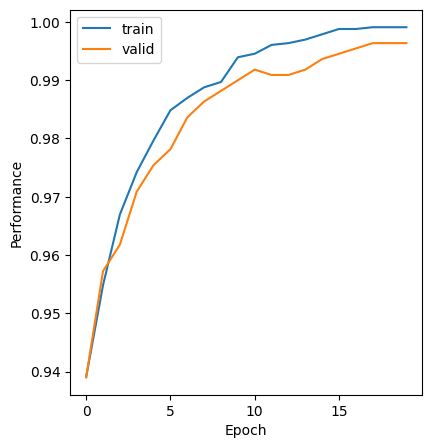

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.legend()
plt.show()

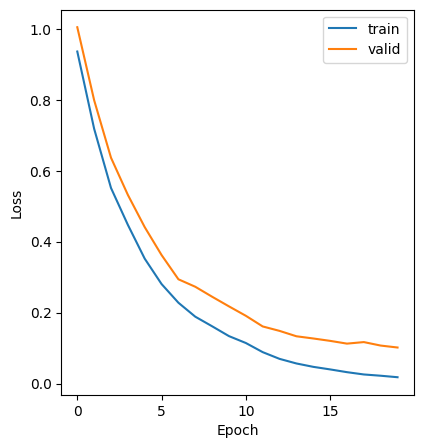

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, train_loss_history, label='train')
plt.plot(epochs, valid_loss_history, label='valid')
plt.legend()
plt.show()

In [ ]:
# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승한다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.9398


In [ ]:
# 문장을 정의
sentence1 = "삼십대의 비율은 감소한다."
sentence2 = "삼십대의 비율은 증가하게된다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.2087



#Test

In [ ]:
# 빈 리스트를 생성하여 원래 데이터셋 형식으로 변환된 데이터를 저장
nli_test_data = []

# 각 트리플릿을 원래 데이터셋 형식으로 변환
for input_example in test_dataset:
    anchor_sentence = input_example.texts[0]
    positive_sentence = input_example.texts[1]
    negative_sentence = input_example.texts[2]

    # 긍정적 예를 1로 레이블링
    nli_test_data.append({'sentence1': anchor_sentence, 'sentence2': positive_sentence, 'gold_label': 1})

    # 부정적 예를 0으로 레이블링
    nli_test_data.append({'sentence1': anchor_sentence, 'sentence2': negative_sentence, 'gold_label': 0})

# original_format_data에는 원래 데이터셋 형식으로 변환된 데이터가 저장됨

In [ ]:

import pandas as pd


# https://wikidocs.net/154530
import numpy as np
import pandas as pd
import urllib.request
from sentence_transformers import SentenceTransformer

sbert_kor = SentenceTransformer('/content/output/KoSimCSE-roberta-2023-10-25_08-21-57')

from numpy import dot
from numpy.linalg import norm


def get_similarity(ans, right_ans, use="cosine"):
    # Cosine Similarity
    if use == "cosine":
        return dot(ans, right_ans) / (norm(ans) * norm(right_ans))

    # Euclidean
    if use == "euclidean":
        if norm(ans - right_ans) == norm(ans - right_ans):
            return norm(ans - right_ans)
        else:
            return -1

    # Pearson
    if use == "pearson":
        return dot((ans - np.mean(ans)), (right_ans - np.mean(right_ans))) / (
                    (norm(ans - np.mean(ans))) * (norm(right_ans - np.mean(right_ans))))




nli_test_data
# original_format_data 리스트를 Pandas 데이터프레임으로 변환
nli_test_data = pd.DataFrame(nli_test_data)
prediction = []
for data in nli_test_data.iloc:
    right_ans = data['sentence1']
    student_ans = data['sentence2']
    label = data['gold_label']
    # print(right_ans, '//', student_ans, '//', label)

    right_ans_emb = sbert_kor.encode([right_ans])
    stu_ans_emb = sbert_kor.encode([student_ans])

    sim = get_similarity(right_ans_emb[0], stu_ans_emb[0], use="cosine")
    prediction.append(sim)

nli_test_data['predict(cosine_sim)'] = prediction


# %%

def threshhold_num(n=0.6):
    def threshold(pred):
        if pred > n:
            return 1
        elif pred <= n:
            return 0

    return threshold


nli_test_data['>0.6'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.6))
nli_test_data['>0.7'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.7))
nli_test_data['>0.8'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.8))
nli_test_data['>0.9'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.9))
# df_valid_v1.head(50)

# %%

nli_test_data.to_csv('./test.csv')

# %%
def get_acc(thresh):
    cnt = 0
    for idx in range(len(nli_test_data)):
      if nli_test_data['gold_label'][idx] == nli_test_data[f'>{thresh}'][idx]:
        cnt += 1
    print("threshold",thresh," accuracy:",cnt / len(nli_test_data))


get_acc(0.6)
get_acc(0.7)
get_acc(0.8)
get_acc(0.9)


threshold 0.6  accuracy: 0.9745685740236149
threshold 0.7  accuracy: 0.9559491371480472
threshold 0.8  accuracy: 0.8978201634877384
threshold 0.9  accuracy: 0.7479564032697548


정밀도: 0.9824561403508771
재현율: 0.9663941871026339
F1 점수: 0.9743589743589742
혼동 행렬:
 [[1082   19]
 [  37 1064]]


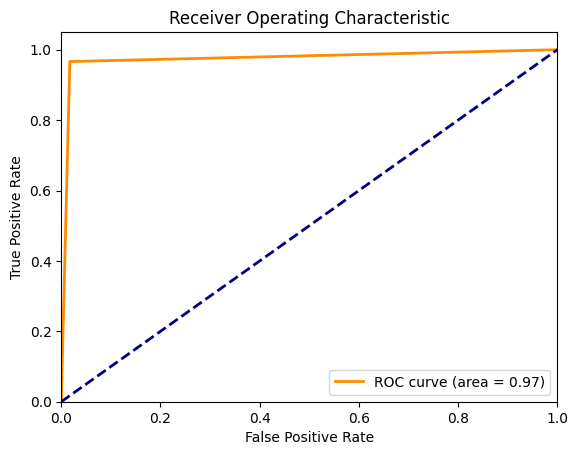

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 레이블과 실제 레이블 가져오기
predicted_labels = nli_test_data['>0.6']  # 이진 분류 예측 레이블
true_labels = nli_test_data['gold_label']

# 정밀도 계산
precision = precision_score(true_labels, predicted_labels)

# 재현율 계산
recall = recall_score(true_labels, predicted_labels)

# F1 점수 계산
f1 = f1_score(true_labels, predicted_labels)

# 혼동 행렬 생성
confusion = confusion_matrix(true_labels, predicted_labels)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 점수:", f1)
print("혼동 행렬:\n", confusion)

# 실제 레이블과 예측 확률을 사용하여 ROC 곡선 및 AUC 값을 계산
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_labels)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()